### Stacking ESA SIC & ERA5
This notebook was used to combine the downloaded CEDA/ESA SIC data and ERA5 data into a single zarr stack. 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os 
import warnings
import rioxarray
import datetime
import glob
import zarr

/Users/Zach/miniforge3/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [35]:
# Get daily SIC from the CEDA dataset
sic = xr.open_zarr('CEDA_SIC.zarr')
sic = sic.resample(time='D').mean()  # Take daily mean

In [36]:
# Get daily ERA5 data from the NetCDF files
fns = glob.glob('era5/*/*.nc')

era5 = xr.open_mfdataset(fns)
era5 = era5.resample(time='D').mean()

# Reproject to the Lambert projection to match the CEDA dataset
crs = '+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +units=km +no_defs +type=crs'
era5 = era5.rio.write_crs(4326).rio.reproject(crs, nodata=np.nan)

# Regrid to the grid of the CEDA dataset
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    era5 = era5.interp({'x':sic.x.values, 'y':sic.y.values})

# Limit to available CEDA dates
era5 = era5.sel(time=slice(min(sic.time), max(sic.time)))

In [37]:
ds = sic.merge(era5).chunk({'time':30, 'x':-1, 'y':-1})
ds = ds.rename({'ice_conc': 'ceda_sic', 'siconc': 'era5_sic'})
ds['era5_sic'] = ds['era5_sic'] * 100

In [38]:
ds['era5_sic_bin'] = xr.where((np.logical_not(np.isnan(ds.era5_sic))), ds.era5_sic > 15, np.nan)
ds['ceda_sic_bin'] = xr.where((np.logical_not(np.isnan(ds.ceda_sic))), ds.ceda_sic > 15, np.nan)

In [39]:
ds.to_zarr('data_full.zarr', mode='w')

#### The ESA SIC data contains a gap in 2011 between satellite launches, therefore we can stitch together sept 2011 - oct 2012

In [50]:
ds_skip_gap = xr.concat([
    ds.sel(time=slice(None, datetime.datetime(2011, 9, 30))), 
    ds.sel(time=slice(datetime.datetime(2012, 10, 1), None))
    ], dim='time')

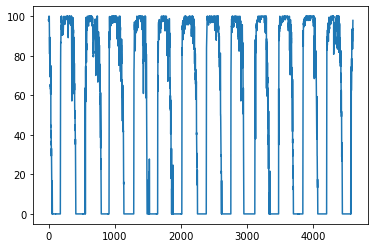

In [52]:
plt.plot(ds_skip_gap.isel(x=25, y=25).ceda_sic)